In [104]:
!pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [105]:
import networkx as nx
import numpy as np
import torch
import random
import matplotlib.pyplot as plt

SEED = 8
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Define the shortest path model class

In [106]:
class ShortestPathModel():

    def __init__(self, grid):
        # grid (tuple): size of grid network
        self.grid = grid
        # arcs/edges of the network
        self.arcs = self.getArcs()
        # creating a network model and its associated edges
        self.model, self.edges = self.getModel()
        # number of edges with cost
        self.num_cost = self.get_num_cost()

    # method to get the list of arcs/edges for the grid network
    def getArcs(self):
        arcs = []
        for i in range(self.grid[0]):
            # edges along the rows
            for j in range(self.grid[1] - 1):
                v = i * self.grid[1] + j
                arcs.append((v, v + 1))
            # edges along the columns
            if i == self.grid[0] - 1:
                # no downward column connection at the last row
                continue 
            for j in range(self.grid[1]):
                v = i * self.grid[1] + j
                arcs.append((v, v + self.grid[1]))
        return arcs

    # build an optimization model
    def getModel(self):
        # build graph as optimization model
        g = nx.Graph()
        # add arcs as variables
        g.add_edges_from(self.arcs, cost=0)
        return g, g.edges

    # set the optimization objective to minimize the total cost
    def setObj(self, costs):
        for i, e in enumerate(self.arcs):
            self.model.edges[e]["cost"] = costs[i]

    # obtain the optimal solution and objective value
    def solve(self):
        # solve using dijkstra algorithm
        path = nx.shortest_path(self.model, weight="cost", source=0, target=self.grid[0]*self.grid[1]-1)
        # convert path into active edges
        edges = []
        u = 0
        for v in path[1:]:
            edges.append((u,v))
            u = v
        # initial solution and objective
        sol = np.zeros(self.num_cost)
        obj = 0
        # convert active edges into solution and obj
        for i, e in enumerate(self.arcs):
            if e in edges:
                # active edge
                sol[i] = 1 
                # cost of active edge
                obj += self.model.edges[e]["cost"] 
        return sol, obj
    
    # count the number of edges in the network
    def get_num_cost(self):
        # this is also the number of costs to be predicted
        return len(self.arcs)

In [107]:
grid = (3,3)
opt_model = ShortestPathModel(grid=grid)

In [108]:
opt_model.getArcs()

[(0, 1),
 (1, 2),
 (0, 3),
 (1, 4),
 (2, 5),
 (3, 4),
 (4, 5),
 (3, 6),
 (4, 7),
 (5, 8),
 (6, 7),
 (7, 8)]

In [109]:
opt_model.get_num_cost()

12

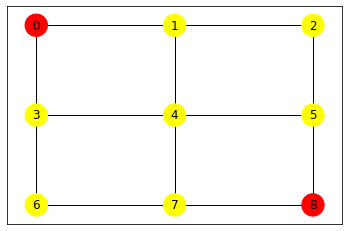

In [110]:
# visualize the graph
# unique nodes in the graph
list_nodes = list(opt_model.model.nodes)

# obtain coordinate for each node in the graph
node_pos = {}
for node in list_nodes:
    node_pos[node] = (int(node%grid[0]), -int(node/grid[1]))

# color the start and sink nodes red and rest yellow
node_col = ['yellow' if not node in [list_nodes[0], list_nodes[-1]] else 'red' for node in list_nodes]
# draw the graphical network
nx.draw_networkx(opt_model.model, node_pos, node_color= node_col, node_size=500)

In [111]:
# solving the 3x3 shortest path problem
opt_model.setObj(costs=[1]*opt_model.get_num_cost())
path = nx.shortest_path(opt_model.model, weight="cost", source=0, target=opt_model.grid[0]*opt_model.grid[1]-1)

In [112]:
path

[0, 1, 2, 5, 8]

# Run the model for 5x5 grid

In [113]:
# grid graph size
grid = (5,5)

# initialize the optimization model
opt_model = ShortestPathModel(grid) 

# set random cost
cost = [random.random() for _ in range(opt_model.get_num_cost())]

# set objective function
opt_model.setObj(cost) 

# solve the optimization model
sol, obj = opt_model.solve()

# store active edges
sol_edges = []
for i, e in enumerate(opt_model.arcs):
    if sol[i] > 1e-3:
        sol_edges.append(e)

In [114]:
print('Obj: {}'.format(obj))
print(sol_edges)

Obj: 1.9975628342989649
[(0, 1), (1, 6), (6, 7), (7, 8), (8, 13), (13, 14), (14, 19), (19, 24)]


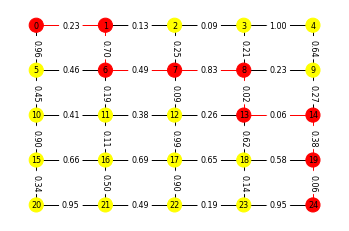

In [115]:
# obtain unique node indices as a list
list_nodes = list(opt_model.model.nodes)

# positional encoding for each node as a dictionary
node_pos = {}
for node in list_nodes:
    node_pos[node] = (int(node%grid[0]), -int(node/grid[1]))

# edge cost as a dictionary
edge_cost = {}
for i, edge in enumerate(list(opt_model.model.edges)):
    edge_cost[edge] = "{:.2f}".format(cost[i])

# selected nodes as a list
sol_nodes = []
for i, j in sol_edges:
    if i not in sol_nodes:
        sol_nodes.append(i)
    if j not in sol_nodes:
        sol_nodes.append(j)

# if the node is in the shortest path, set it to red, else set it to yellow
node_col = ['yellow' if not node in sol_nodes else 'red' for node in list_nodes]

# If the edge is in the shortest path set it to red, else set it to black
edge_col = ['black' if not edge in sol_edges else 'red' for edge in list(opt_model.model.edges)]

# draw the nodes
nx.draw_networkx(opt_model.model, node_pos, node_color= node_col, node_size=200, font_size=8)

# draw the edges
nx.draw_networkx_edges(opt_model.model, node_pos, edge_color = edge_col)

# draw the edge labels
nx.draw_networkx_edge_labels(opt_model.model, node_pos, edge_labels=edge_cost, font_size=8)

# show the plot
plt.axis('off')
plt.figure(1, figsize=(200, 200))
plt.show()

# Define the SPO+ loss function

## Test code for one example

In [116]:
from torch.autograd import Function

class SPOPlusFunc(Function):
    # decorate as static method that belongs to the class only
    @staticmethod
    # forward pass for SPO+
    def forward(ctx, pred_cost, true_cost, true_sol, true_obj,
                optmodel):
        # obtain SPO+ loss and suggested traveling path by solving an optimization model 
        sol, loss = solve_in_forward(pred_cost, true_cost, true_sol, true_obj, optmodel)
        # convert to tensor
        loss = np.array(loss)      
        loss = torch.FloatTensor(loss)
        sol = np.array(sol)
        sol = torch.FloatTensor(sol)
        # save solutions for backward pass
        ctx.save_for_backward(true_sol, sol)
        # add other objects to ctx
        ctx.optmodel = optmodel
        return loss

    @staticmethod
    # backward pass for SPO+
    def backward(ctx, grad_output):
        # extract saved objects from forward()
        w, wq = ctx.saved_tensors
        optmodel = ctx.optmodel
        # calculate the analytical subgradient in closed-form
        grad = 2 * (w - wq)
        # multiply the gradient wrt input with gradient wrt output using the chain rule
        return grad_output * grad, None, None, None, None

# function to solve optimization in the forward pass
def solve_in_forward(cp, c, w, z, optmodel):
    cp = np.array(cp)
    c = np.array(c)
    # use the new cost 2*pred_cost-true_cost in the optimization model
    new_cost = 2 * cp - c
    # shifting all edge costs upwards to make them positive, or zero
    if np.min(new_cost)<0:
        new_cost = new_cost + np.abs(np.min(new_cost))
    # assign the new cost to the optimization model instance
    optmodel.setObj(new_cost)
    # perform optimization to obtain optimal traveling solution and total cost
    solq, objq = optmodel.solve()
    # calculate SPO+ loss
    loss = -objq + 2 * np.dot(cp, w) - z
    
    return solq, loss


In [117]:
from torch import nn

class SPOPlus(nn.Module):
    def __init__(self, optmodel, dataset=None):
        super().__init__()
        self.optmodel = optmodel
        self.spop = SPOPlusFunc()

    def forward(self, pred_cost, true_cost, true_sol, true_obj):
        loss = self.spop.apply(pred_cost, true_cost, true_sol, true_obj,
                               self.optmodel)
        return loss


In [118]:
spop = SPOPlus(opt_model)
pred_cost = [random.random() for _ in range(opt_model.get_num_cost())]
loss = spop(pred_cost, cost, sol, obj)
loss

tensor(2.1182)

# End-to-end training

## Prepare training data

In [119]:
# synthetic data for shortest path problem
def genData(num_data, num_features, grid, deg=1, noise_width=0, seed=8):
    # set seed
    np.random.seed(seed)
    # number of data instances
    n = num_data
    # dimension of contextual features
    p = num_features
    # dimension of the cost vector
    d = (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0]
    # random matrix parameter B for the coefficients to be learned by prediction model
    B = np.random.binomial(1, 0.5, (d, p))
    # contextual feature vectors
    x = np.random.normal(0, 1, (n, p))
    # cost vectors
    c = np.zeros((n, d))
    # iteratively generate edge costs for each instance
    for i in range(n):
        # cost without noise
        ci = (np.dot(B, x[i].reshape(p, 1)).T / np.sqrt(p) + 3) ** deg + 1
        # rescale
        ci /= 3.5 ** deg
        # noise based on the specified half width of the noise term
        epislon = np.random.uniform(1 - noise_width, 1 + noise_width, d)
        # apply the multiplicative noise
        ci *= epislon
        c[i, :] = ci

    return x, c

In [120]:
n = 2000 # number of instances
p = 5 # number of feature
deg = 4 # polynomial degree
# generate data for grid network (features and costs)
feats, costs = genData(n, p, grid, deg=deg)

In [121]:
# features
print(feats.shape)
print(feats)

(2000, 5)
[[-0.06074935 -2.43448243 -0.33098673  0.47264138 -0.88516841]
 [-0.94402646  0.73457354  2.64294292  0.61175799  0.65766052]
 [ 0.04604598  0.77026263  0.59305273 -0.93344358  0.37543325]
 ...
 [-0.29687019  0.45511836 -0.15959018 -0.76549628 -0.76148503]
 [-0.65785543  1.28125324  1.29164287  1.30754294  0.15057219]
 [ 0.17258779 -0.96249999  0.65382263 -0.08534153  2.07169298]]


In [122]:
# cost coefficients
print(costs.shape)
print(costs)

(2000, 40)
[[0.10251377 0.71540904 0.04528587 ... 0.3131322  0.13514926 0.54643898]
 [2.41890772 0.77194872 3.13833656 ... 0.79132604 0.68804576 0.54643898]
 [0.71670343 0.30309493 0.8771718  ... 0.67780377 0.50971399 0.54643898]
 ...
 [0.33881288 0.33911308 0.19856029 ... 0.34001158 0.37596391 0.54643898]
 [2.59918666 1.10709736 2.76003191 ... 0.59655836 1.49147361 0.54643898]
 [0.47862104 0.51949072 1.43678064 ... 1.59062852 0.31522479 0.54643898]]


In [123]:
# split train test data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=1000, random_state=SEED)

## Prepare dataloader

In [124]:
# optDataset class based on PyTorch Dataset
from torch.utils.data import Dataset
from tqdm import tqdm

# build a Torch Dataset class for the optimization problems
class optDataset(Dataset):
    def __init__(self, model, feats, costs):
        self.model = model # an instance of the optimization model
        self.feats = feats # contextual input features
        self.costs = costs # cost vectors for the objective function
        # find optimal solutions
        self.sols, self.objs = self.getSols()

    # a method to get optimal solutions for all cost vectors
    def getSols(self):
        sols = []
        objs = []
        # iterate through all instances
        for c in tqdm(self.costs):
            sol, obj = self.solve(c)
            sols.append(sol)
            objs.append([obj])
        return np.array(sols), np.array(objs)

    # solve optimization problem to get an optimal solution with given cost
    def solve(self, cost):
        self.model.setObj(cost)
        sol, obj = self.model.solve()
        return sol, obj

    # a method to get data size, i.e., the number of optimization instances
    def __len__(self):
        return len(self.costs)

    # a method to retrieve data tuple, including features, costs, optimal solutions and objective values
    def __getitem__(self, index):
        return (
            torch.FloatTensor(self.feats[index]),
            torch.FloatTensor(self.costs[index]),
            torch.FloatTensor(self.sols[index]),
            torch.FloatTensor(self.objs[index]),
        )

In [125]:
# get optDataest by computing optimal solution for each cost vector
dataset_train = optDataset(opt_model, x_train, c_train)
dataset_test = optDataset(opt_model, x_test, c_test)

100%|██████████| 1000/1000 [00:00<00:00, 6475.92it/s]


In [126]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Single layer linear model

In [127]:
# build linear model
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, (grid[0] - 1) * grid[1] + (grid[1] - 1) * grid[0])
    
    def forward(self, x):
        out = self.linear(x)
        return out

In [128]:
# initialize model
reg = LinearRegression()
# use cuda if available
if torch.cuda.is_available():
    reg = reg.cuda()

In [129]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

## Training with SPO+ loss

In [130]:
class SPOPlus(nn.Module):
    def __init__(self, optmodel, solve_ratio=1, dataset=None):
        super().__init__()
        # optimization model
        self.optmodel = optmodel
        # solution pool
        self.solve_ratio = solve_ratio
        self.solpool = None
        # build carterion
        self.spop = SPOPlusFunc()

    def forward(self, pred_cost, true_cost, true_sol, true_obj):
        loss = self.spop.apply(pred_cost, true_cost, true_sol, true_obj,
                               self.optmodel, self.solve_ratio,
                               self)
        return loss

class SPOPlusFunc(Function):
    @staticmethod
    def forward(ctx, pred_cost, true_cost, true_sol, true_obj,
                optmodel, solve_ratio, module):
        # get device
        device = pred_cost.device
        # convert tenstor
        cp = pred_cost.detach().to("cpu").numpy()
        c = true_cost.detach().to("cpu").numpy()
        w = true_sol.detach().to("cpu").numpy()
        z = true_obj.detach().to("cpu").numpy()
        # solve
        sol, loss = _solve_in_forward(cp, c, w, z, optmodel)
        if solve_ratio < 1:
            module.solpool = np.concatenate((module.solpool, sol))

        loss = np.array(loss)
        # convert to tensor
        loss = torch.FloatTensor(loss).to(device)
        sol = np.array(sol)
        sol = torch.FloatTensor(sol).to(device)
        # save solutions
        ctx.save_for_backward(true_sol, sol)
        # add other objects to ctx
        ctx.optmodel = optmodel
        return loss

    @staticmethod
    def backward(ctx, grad_output):
        """
        Backward pass for SPO+
        """
        w, wq = ctx.saved_tensors
        optmodel = ctx.optmodel
        grad = 2 * (w - wq)
        
        return grad_output * grad, None, None, None, None, None, None, None


def _solve_in_forward(cp, c, w, z, optmodel):
    """
    A function to solve optimization in the forward pass
    """
    # number of instance
    ins_num = len(z)
    # single-core

    loss = []
    sol = []
    for i in range(ins_num):
        new_cost = 2 * cp[i] - c[i]
        if np.min(new_cost)<0:
            new_cost = new_cost + np.abs(np.min(new_cost))
        optmodel.setObj(new_cost)

        # solve
        solq, objq = optmodel.solve()
        objq -= len(solq)*np.abs(np.min(new_cost))
        # calculate loss
        loss.append(objq + 2 * np.dot(cp[i], w[i]) - z[i])
        # solution
        sol.append(solq)
    
    return sol, loss


In [131]:
spop = SPOPlus(opt_model)

In [132]:
def regret(predmodel, optmodel, dataloader):
    # set to evaluation mode
    predmodel.eval()
    loss = 0
    optsum = 0
    # load data
    for data in dataloader:
        x, c, w, z = data
        # pass to cuda if available
        if next(predmodel.parameters()).is_cuda:
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # predict for test set without gradient
        with torch.no_grad():
            cp = predmodel(x).to("cpu").detach().numpy()
        # solve
        for j in range(cp.shape[0]):
            # accumulate loss for all instances in a batch
            loss += calRegret(optmodel, cp[j], c[j].to("cpu").detach().numpy(),
                              z[j].item())
        optsum += abs(z).sum().item()
    # turn back to training mode
    predmodel.train()
    # calculate regret as percentage loss
    return loss / (optsum + 1e-7)

def calRegret(optmodel, pred_cost, true_cost, true_obj):
    new_cost_pred = pred_cost
    # make all edge costs positive
    if np.min(new_cost_pred)<0:
        new_cost_pred = new_cost_pred + np.abs(np.min(new_cost_pred))
    # opt sol for pred cost
    optmodel.setObj(new_cost_pred)
    sol, _ = optmodel.solve()
    # obj with true cost
    obj = np.dot(sol, true_cost)
    loss = obj - true_obj
    return loss

In [133]:
num_epochs = 30
# switch the model to training mode
reg.train()
# store training set loss per batch
loss_log = []
# store test set regret per epoch
loss_log_regret = [regret(reg, opt_model, loader_test)]
for epoch in range(num_epochs):
    # load data in batches
    for i, data in enumerate(loader_train):
        # prepare the necessary ingredients
        x, c, w, z = data
        # pass to cuda if available
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        # calculate SPO+ loss and take average for the whole batch
        loss = spop(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # weight update via SGD
        optimizer.step()
        loss_log.append(loss.item())
    epoch_regret = regret(reg, opt_model, loader_test)
    loss_log_regret.append(epoch_regret)
    print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch+1, loss.item(), epoch_regret*100))

Epoch   1, Loss:   8.4030, Regret:  4.2614%
Epoch   2, Loss:   9.5383, Regret:  1.0153%
Epoch   3, Loss:   6.0231, Regret:  0.7958%
Epoch   4, Loss:   8.9473, Regret:  0.6789%
Epoch   5, Loss:   7.6970, Regret:  0.7645%
Epoch   6, Loss:   5.1468, Regret:  0.6890%
Epoch   7, Loss:   6.1203, Regret:  0.8461%
Epoch   8, Loss:   4.5006, Regret:  0.7280%
Epoch   9, Loss:   4.7199, Regret:  0.6893%
Epoch  10, Loss:   5.0105, Regret:  0.8014%
Epoch  11, Loss:   6.9947, Regret:  0.7394%
Epoch  12, Loss:   3.1332, Regret:  0.7382%
Epoch  13, Loss:   3.1318, Regret:  0.6611%
Epoch  14, Loss:   2.7798, Regret:  0.7916%
Epoch  15, Loss:   4.8360, Regret:  0.6132%
Epoch  16, Loss:   4.6173, Regret:  0.6179%
Epoch  17, Loss:   6.8318, Regret:  0.6555%
Epoch  18, Loss:   2.2899, Regret:  0.8415%
Epoch  19, Loss:   2.8346, Regret:  0.6690%
Epoch  20, Loss:   3.7003, Regret:  0.6730%
Epoch  21, Loss:   2.8920, Regret:  0.6720%
Epoch  22, Loss:   6.2224, Regret:  0.6911%
Epoch  23, Loss:   3.6971, Regre

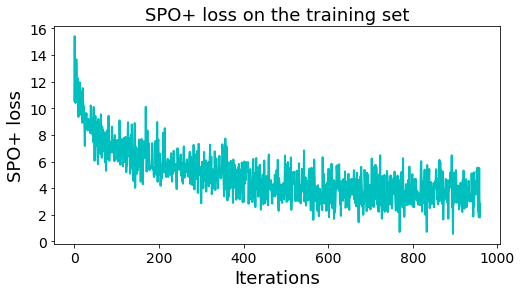

In [134]:
# plot training loss per iteration
plt.figure(figsize=(8, 4))
plt.plot(loss_log, color="c", lw=2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Iterations", fontsize=18)
plt.ylabel("SPO+ loss", fontsize=18)
plt.title("SPO+ loss on the training set", fontsize=18)
plt.show()

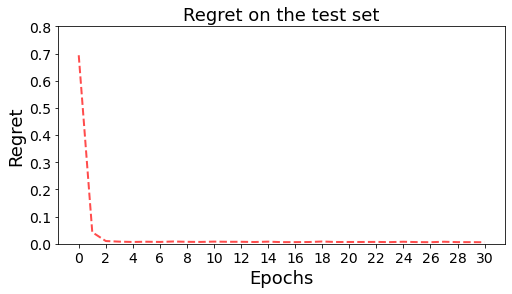

In [135]:
# plot the regret on test set
fig = plt.figure(figsize=(8, 4))
plt.plot(range(num_epochs+1), loss_log_regret, color="red", ls="--", alpha=0.7, lw=2)
plt.xticks(range(0, num_epochs+1, 2), fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0, 0.8)
plt.xlabel("Epochs", fontsize=18)
plt.ylabel("Regret", fontsize=18)
plt.title("Regret on the test set", fontsize=18)
plt.show()

In [136]:
loss_log_regret

[0.6937563955901297,
 0.04261393545177128,
 0.010153107747665894,
 0.007957828310161558,
 0.0067889393484323705,
 0.007645168854529444,
 0.006889530586759311,
 0.008460851904580916,
 0.0072797766456474825,
 0.006893452595086768,
 0.008013507946985896,
 0.007394427302660634,
 0.007382405346681048,
 0.00661078729018553,
 0.007915513396689004,
 0.006131705485279496,
 0.006179050419415371,
 0.006554917508516889,
 0.008415154746665062,
 0.006689675228704078,
 0.0067304246105847725,
 0.006719885081221459,
 0.00691122595156663,
 0.0062183663969712834,
 0.007524793048132227,
 0.006300259985744753,
 0.005901436139799561,
 0.0075765153086522225,
 0.006151442208634412,
 0.006104034944349521,
 0.005736620529723018]